In [1]:
import datetime

apalis = {
    # really Tractor02
    "Tractor01": ["/home/tjw/Downloads/apalis24/Tractor02-gps01.csv",
                  "/home/tjw/Downloads/apalis24/Tractor02-gps02.csv"],
    
    # really Tractor03
    "Tractor02": ["/home/tjw/Downloads/apalis24/Tractor03-gps01.csv",
                  "/home/tjw/Downloads/apalis24/Tractor03-gps02.csv"],
    
    # really Tractor04
    "Tractor03": ["/home/tjw/Downloads/apalis24/Tractor04-gps01.csv",
                  "/home/tjw/Downloads/apalis24/Tractor04-gps02.csv",
                  "/home/tjw/Downloads/apalis24/Tractor04-gps03.csv"]
}

gopro = {
    "Tractor01": ["/home/tjw/Documents/gopro24/Tractor02"], # really Tractor02
    "Tractor02": ["/home/tjw/Documents/gopro24/Tractor03"], # really Tractor03
    "Tractor03": ["/home/tjw/Documents/gopro24/Tractor04"]  # really Tractor04
}

canbus = {
    "apalis1": "/home/tjw/Documents/apalis24/2024_apalis1.sql",
    "apalis2": "/home/tjw/Documents/apalis24/2024_apalis2.sql",
    "apalis3": "/home/tjw/Documents/apalis24/2024_apalis3.sql",
    "apalis4": "/home/tjw/Documents/apalis24/2024_apalis4.sql"
}

isoblue = {
    # really Tractor02
    "Tractor01": {
        "apalis1": {"start": datetime.datetime(2024,1,1),
                    "end": datetime.datetime(2024,6,17)},
        "apalis3": {"start": datetime.datetime(2024,6,17),
                    "end": datetime.datetime(2024,10,31)}
    },

    # really Tractor03
    "Tractor02": {
        "apalis2": {"start": datetime.datetime(2024,1,1),
                    "end": datetime.datetime(2024,8,22)},
        "apalis4": {"start": datetime.datetime(2024,1,1),
                    "end": datetime.datetime(2024,10,31)}
    },

    # really Tractor04
    "Tractor03": {
        "apalis3": {"start": datetime.datetime(2024,1,1),
                    "end": datetime.datetime(2024,6,17)},
        "apalis1": {"start": datetime.datetime(2024,6,17),
                    "end": datetime.datetime(2024,8,22)},
        "apalis2": {"start": datetime.datetime(2024,8,22),
                    "end": datetime.datetime(2024,10,31)}
    }
}

maintenance = [ # all the dates of data swaps
    datetime.datetime(2024, 5, 5),
    datetime.datetime(2024, 5,19),
    datetime.datetime(2024, 5,28),
    datetime.datetime(2024, 6, 5),
    datetime.datetime(2024, 6,10),
    datetime.datetime(2024, 6,17),
    datetime.datetime(2024, 6,28),
    datetime.datetime(2024, 7,17),
    datetime.datetime(2024, 7,27),
    datetime.datetime(2024, 8,22),
    datetime.datetime(2024, 9, 1),
    datetime.datetime(2024, 9, 9),
    datetime.datetime(2024, 9,26),
    datetime.datetime(2024,10,17)
]


In [2]:
def stamp(dt):
    # minute = dt.minute - (dt.minute % 10)
    # return f"{dt.date()}_{dt.hour:02}:{minute:02}"
    return f"{dt.date()}_{dt.hour:02}:{dt.minute:02}"

def unstamp(st):
    date, time = st.split("_")
    yy,mm,dd = date.split("-")
    hh,mn = time.split(":")
    #hh,mn = time, 0
    return datetime.datetime(
        year=int(yy), month=int(mm), day=int(dd),
        hour=int(hh), minute=int(mn)
    )

In [ ]:
# Get line totals for DB dumps
import subprocess

line_total = {}

for db in canbus:
    line_total[db] = int(subprocess.check_output(["wc", "-l", canbus[db]]).decode().split()[0])

# line_total = {'apalis1': 274850703, 'apalis2': 350961387, 'apalis3': 99362332, 'apalis4': 33419054}

In [3]:
def roll_avg(frame, new):
    N = frame[1] + 1
    output = frame[0]*(1 - 1/N) + new/N
    return output, N


In [5]:
# Read Isoblue CAN data
import time
from dateutil import parser
MAGIC = 1/900 # empirical scaling factor for CAN bus ground speed to get m/s
BAR_W = 49

c_data = {}

for tractor in isoblue:
    c_data[tractor] = {"speed":{}, "stamps":[]}

    for db in isoblue[tractor]:
        stime = time.time()
        start = isoblue[tractor][db]["start"]
        end = isoblue[tractor][db]["end"]

        with open(canbus[db]) as file:
            i = 0
            for line in file:
                if "can0" in line:
                    l = line.split("\t")
                    arb = l[2]
                    if arb[2:6] == "FEF1": # vehicle ground speed PGN
                        
                        # Get datetime of line
                        timestamp = l[0].split(".")[0]
                        if "+" in timestamp:
                            timestamp = timestamp.split("+")[0]
                        dt = parser.isoparse(timestamp)
                        
                        # Check that line is within parameters of tractor
                        if dt >= start and dt < end:
                            hex_data = l[3]
                            speed = MAGIC * (256*int(hex_data[4:6], 16) + 
                                             int(hex_data[6:8], 16))
                            
                            # Save data to output
                            st = stamp(dt)
                            if st not in c_data[tractor]["speed"]:
                                c_data[tractor]["speed"][st] = (speed, 1)
                            else:
                                c_data[tractor]["speed"][st] = roll_avg(
                                    c_data[tractor]["speed"][st], speed
                                )
                            
                            if st not in c_data[tractor]["stamps"]:
                                c_data[tractor]["stamps"].append(st)
            
                # Print progress
                i += 1
                if i % 250_000 == 0:
                    y = time.time() - stime
                    x = i/line_total[db]
                    pct = round(BAR_W*x)
                    bar = "="*pct
                    space = " "*(BAR_W-pct)
                    print(f"[{tractor}/{db}]: |{bar}>{space}| ~{round((y/x)-y)}s remain...   ", end="\r")
        print(f"[{tractor}/{db}] Finished with {db} in {round(time.time() - stime)}s {' '*BAR_W}")
    print(f"**[{tractor}] Found a total of {len(c_data[tractor]['speed'])} speeds")


[Tractor01/apalis1] Finished with apalis1 in 162s                                                  
[Tractor01/apalis3] Finished with apalis3 in 89s                                                  
**[Tractor01] Found a total of 6267 speeds
[Tractor02/apalis2] Finished with apalis2 in 155s                                                  
[Tractor02/apalis4] Finished with apalis4 in 17s                                                  
**[Tractor02] Found a total of 1007 speeds
[Tractor03/apalis3] Finished with apalis3 in 46s                                                  
[Tractor03/apalis1] Finished with apalis1 in 123s                                                  
[Tractor03/apalis2] Finished with apalis2 in 442s                                                  
**[Tractor03] Found a total of 11693 speeds


In [7]:
import json

# # Write c_data to json
# with open("/home/tjw/Documents/apalis24/c_data.json", "w") as file:
#     json.dump(c_data, file)

# Read c_data from json
with open("/home/tjw/Documents/apalis24/c_data.json", "r") as file:
    c_data = json.load(file)

In [18]:
print(f"2024 Telematics data:")
for tractor in c_data:
    print(f"{tractor} has {len(c_data[tractor]['stamps'])/60:0.1f} hours of wheel speed data")

2024 Telematics data:
Tractor01 has 104.5 hours of wheel speed data
Tractor02 has 16.8 hours of wheel speed data
Tractor03 has 194.9 hours of wheel speed data


In [5]:
# Read Isoblue GPS data
from dateutil import parser

a_data = {}
SKIP = 1
MIN_SPEED = 0 # cutoff for ground speed needed to say they were actually working

for tractor in apalis:
    a_data[tractor] = {"datetime":[], "longlat":[], "stamps": [], "speed": {}}
    for csv in apalis[tractor]:
        print(f"Tractor {tractor}: Parsing {csv}...", end=" "*10)
        with open(csv) as file:
            i = 0
            for line in file.readlines()[1:]:
                i += 1
                if i % SKIP == 0:
                    # Parse data from CSV
                    time, lat, lng = line.split(",")
                    lat = float(lat)
                    lng = float(lng.rstrip())
                    time = parser.isoparse(time)
                    
                    # Add data to dict
                    a_data[tractor]["datetime"].append(time)
                    a_data[tractor]["longlat"].append((lng, lat))
                    st = stamp(time)
                    
                    if st not in a_data[tractor]["stamps"]:
                        # if st in c_data[tractor]["speed"]:
                        #     if c_data[tractor]["speed"][st][0] > MIN_SPEED:
                        #         a_data[tractor]["stamps"].append(st)
                        #     else:
                        #         pass # don't count periods with confirmed no-movement
                        # else:
                        a_data[tractor]["stamps"].append(st)
        print(f"\rTractor {tractor}: Finished with {csv}!")


In [ ]:
import json

# # Serialize a_data into json
# with open("/home/tjw/Downloads/apalis24/a_data.json", "w") as file:
#     jdata = {}
#     for tractor in a_data:
#         jdata[tractor] = {
#             "datetime": [str(dt) for dt in a_data[tractor]["datetime"]],
#             "longlat": a_data[tractor]["longlat"],
#             "stamps": a_data[tractor]["stamps"]
#         }
#     json.dump(jdata, file)

# Read a_data from json
with open("/home/tjw/Downloads/apalis24/a_data.json", "r") as file:
    jdata = json.load(file)
    a_data = {}
    for tractor in jdata:
        a_data[tractor] = {
            "datetime": [parser.isoparse(jdt) for jdt in jdata[tractor]["datetime"]],
            "longlat": jdata[tractor]["longlat"],
            "stamps": jdata[tractor]["stamps"]
        }


In [7]:
for tractor in a_data:
    print(f"{tractor} has {len(a_data[tractor]['stamps'])/60:0.1f} hours of GPS data")

Tractor01 has 826.9 hours of GPS data
Tractor02 has 686.0 hours of GPS data
Tractor03 has 888.6 hours of GPS data


In [10]:
def goproParse(jsondata):
    gps = []
    times = []
    stamps = []
    for frame in jsondata:
        time = parser.isoparse(frame["gps_time"])
        if time.year == 2024:
            times.append(time)
            stamps.append(stamp(time))
            lon = frame["cam_gps"]["lon"]
            lat = frame["cam_gps"]["lat"]
            gps.append((lon,lat))
    return (times, gps, stamps)

In [11]:
import json, os
g_data = {}
for tractor in gopro:
    g_data[tractor] = {"datetime":[], "longlat":[], "stamps":[]}
    for folder in gopro[tractor]:
        for file in os.listdir(folder):
            if "metadata" not in file:
                with open(os.path.join(folder, file)) as file:
                    times, gps, stamps = goproParse(json.load(file))
                    g_data[tractor]["longlat"] += (gps)
                    g_data[tractor]["datetime"] += times

                    for st in stamps:
                        if st not in g_data[tractor]["stamps"]:
                            g_data[tractor]["stamps"].append(st)


In [12]:
def same(x1, x2): # return intersection of two lists
    output = []
    for x in x1:
        if x in x2:
            output.append(x)
    return output

def inany(x1, x2): # return union of two lists
    output = [x for x in x1]
    for x in x2:
        if x not in output:
            output.append(x)
    return output


In [13]:
tractors = same(gopro, apalis)

print(tractors)

['Tractor01', 'Tractor03']


In [18]:
u_data = {}

for tractor in tractors:
    u_data[tractor] = {}
    u_data[tractor]["stamps"] = same(c_data[tractor]["stamps"], g_data[tractor]["stamps"])
    u_data[tractor]["longlat"] = []
    u_data[tractor]["datetime"] = []

    for i in range(0, len(g_data[tractor]["datetime"])):
        if stamp(g_data[tractor]["datetime"][i]) in u_data[tractor]["stamps"]:
            u_data[tractor]["datetime"].append(g_data[tractor]["datetime"][i])
            u_data[tractor]["longlat"].append(g_data[tractor]["longlat"][i])


In [15]:
import geojson
from shapely.geometry import Polygon

with open("County_Boundaries_of_Indiana_2023.geojson") as file:
    IN_COUNTIES = geojson.load(file)

counties = {}
for i in range(len(IN_COUNTIES["features"])):
    name = IN_COUNTIES["features"][i]["properties"]["name"]
    name = name.split(" County")[0]
    counties[name] = Polygon(IN_COUNTIES["features"][i]["geometry"]["coordinates"][0][0])


In [16]:
# Copied from https://stackoverflow.com/a/70533052
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

In [17]:
from shapely.geometry import Point

# Greedy (but still slow) County Checker
def check_county(coords, county):
    for point in coords:
        if county.contains(Point(point)):
            return True
    return False

# Greedy tractor-county checker
def tc_check(dataset, county):
    for tractor in dataset:
        if check_county(dataset[tractor]["longlat"], county):
            return True
    return False


In [ ]:
# Check which counties had which/both sources
data_counties = {}
for county in counties:
    data_counties[county] = ""
    if tc_check(u_data, counties[county]):
        data_counties[county] = "Both"
    else:
        if tc_check(a_data, counties[county]):
            data_counties[county] += "A"
        if tc_check(g_data, counties[county]):
            data_counties[county] += "G"
    
    print(f"{county}: {data_counties[county]}")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as pch

fig, ax = plt.subplots()
for county in counties:
    if data_counties[county] == "Both":
        plot_polygon(ax, counties[county], facecolor="goldenrod", edgecolor="black")
    elif data_counties[county] in ["A", "G", "AG"]:
        plot_polygon(ax, counties[county], facecolor="silver", edgecolor="black")
    else:
        plot_polygon(ax, counties[county], facecolor="white", edgecolor="black")

# Create legend
gold = pch.Patch(color="goldenrod", label="Full Record")
silver = pch.Patch(color="silver", label="Partial Record")
fig.legend([gold, silver], ["Monitored", "Partial Data"], loc="upper center", ncol=2)

ax.set_xticklabels("")
ax.set_yticklabels("")
fig.set_size_inches(6,6)
ax.set_aspect(1.0)


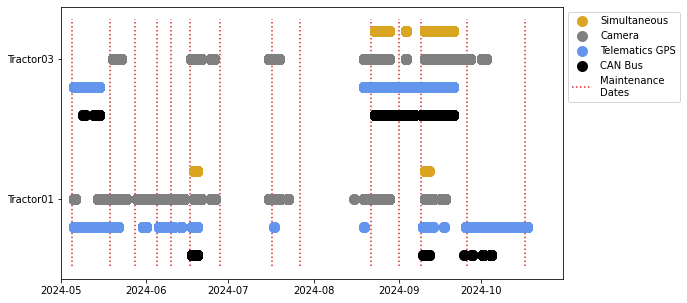

In [131]:
import matplotlib.pyplot as plt
x= {}
fig = plt.figure()

i = 0
for tractor in tractors:
    # Both data
    x[tractor] = [unstamp(date) for date in u_data[tractor]["stamps"]]
    gold = plt.scatter(x[tractor], [i+0.2 for _ in x[tractor]], color="goldenrod", linewidths=5, label="Both")
    
    # GoPro Data
    x[tractor] = [unstamp(date) for date in g_data[tractor]["stamps"]]
    grey = plt.scatter(x[tractor], [i for _ in x[tractor]], color="grey", linewidths=5, label="Camera")
    
    # IsoBlue Data
    x[tractor] = [unstamp(date) for date in a_data[tractor]["stamps"]]
    blue = plt.scatter(x[tractor], [i-0.2 for _ in x[tractor]], color="cornflowerblue", linewidths=5, label="Telematics")
    
    # CAN Data
    x[tractor] = [unstamp(date) for date in c_data[tractor]["stamps"]]
    black = plt.scatter(x[tractor], [i-0.4 for _ in x[tractor]], color="black", linewidths=5, label="CAN Bus")

    i += 1

bot, top = plt.ylim()
red = plt.vlines(maintenance, ymin=bot, ymax=top, colors="tab:red", linestyles="dotted", zorder=0)

plt.legend([gold, grey, blue, black, red], ["Simultaneous", "Camera", "Telematics GPS", "CAN Bus", "Maintenance\nDates"], bbox_to_anchor=(1,1))
inum = [i for i in range(len(x))]
plt.yticks(ticks=inum, labels=tractors)
fig.set_size_inches(9,5)
plt.xlim(datetime.datetime(2024, 5, 1), datetime.datetime(2024, 10, 31))
plt.show()

In [65]:
g_unfiltered = {}
import pandas as pd

for tractor in tractors:
    time = []
    lati = []
    long = []
    
    for i in range(len(g_data[tractor]["datetime"])):
        dt = g_data[tractor]["datetime"][i]
        if stamp(dt) in c_data[tractor]["stamps"]:
            time.append(dt.replace(microsecond=0))
            lon, lat = g_data[tractor]["longlat"][i]
            lati.append(float(lat))
            long.append(float(lon))
    
    g_unfiltered[tractor] = pd.DataFrame({
        "datetime": time,
        "lat": lati,
        "lon": long
    })
    g_unfiltered[tractor].sort_values(by="datetime", inplace=True, ignore_index=True)

g_unfiltered["Tractor03"]

,datetime,lat,lon
0,2024-06-18 12:36:56+00:00,40.758068,-87.114002
1,2024-06-18 12:36:58+00:00,40.758059,-87.113869
2,2024-06-18 12:36:59+00:00,40.758041,-87.113751
3,2024-06-18 12:37:00+00:00,40.758021,-87.113627
4,2024-06-18 12:37:01+00:00,40.758001,-87.113503
...,...,...,...
89691,2024-09-11 21:23:26+00:00,41.052645,-87.270655
89692,2024-09-11 21:23:27+00:00,41.052646,-87.270655
89693,2024-09-11 21:23:28+00:00,41.052646,-87.270655
89694,2024-09-11 21:23:29+00:00,41.052646,-87.270656


In [ ]:
# Pasted-in tractor_filter, from 2024-12-04
import datetime
import numpy as np
import pandas as pd
from scipy.linalg import LinAlgError
from scipy.interpolate import RBFInterpolator
from scipy.signal import savgol_filter

def tractor_filter(
    data: dict,
    threshold_session: float = 5*60.0,
    threshold_track: float = 60.0,
    window_size: int = 30,
    spline_smoothing: float = 0.000000001):
    """
    Filters a 1 Hz GPS dataset with Savitzky-Golay and Radial Basis Functions
    
    Parameters:
        data (dict): Dicts for each [tractor] with [datetime], [lat]itude, and [lon]gitude lists
        threshold_session (float): how many seconds before consecutive GPS coordinates should be considered part of seaparate "sessions"
        threshold_track (float): how many seconds before consecutive GPS coordinates should be considered part of seaparate "tracks" (to be combined with multiquadric splines)
        window_size (int): number of points in window for Savitzky-Golay filtering
        spline_smoothing (float): epsilon factor for RBF spline's multiquadric kernel
    
    Returns:
        dict: DataFrame for each [tractor] with datetime, latitude, and longitude columns
    """
    threshold_frame = 1.4 # Fuzzy cutoff for 1 Hz requirement (split frames to be combined with linear interpolation)
    
    # Separate raw data into different sessions, tracks, and frames
    a_tracks = {}
    for tractor in data:
        a_tracks[tractor] = [
            # nested lists: [session][track][frame]
        ]
        
        sx = 0
        for i in range(1, len(data[tractor]["datetime"])):
            delta = (data[tractor]["datetime"][i]
                   - data[tractor]["datetime"][i-1]).total_seconds()
            if delta > threshold_frame:
                df = pd.DataFrame({
                    "time": data[tractor]["datetime"][sx:i],
                    "lat": data[tractor]["lat"][sx:i],
                    "lon":  data[tractor]["lon"][sx:i]
                }) # N.B: python slices are start-inclusive, end-exclusive
                
                if len(a_tracks[tractor]) > 0:
                    time = df["time"].iloc[0]
                    otime = a_tracks[tractor][-1][-1][-1]["time"].iloc[-1]
                    delta = (time - otime).total_seconds()
                
                if (delta > threshold_track) or (len(a_tracks[tractor]) == 0):
                    if (delta > threshold_session) or (len(a_tracks[tractor]) == 0):
                        # New Session
                        a_tracks[tractor].append([[df.copy()]])
                    else:
                        # New Track for last session
                        a_tracks[tractor][-1].append([df.copy()])
                else:
                    # New Frame for last track of last session
                    a_tracks[tractor][-1][-1].append(df.copy())
                
                # Reset starting point for next frame
                sx =  i
    
    # Combine all frames for each track
    for tractor in a_tracks:
        for session in range(len(a_tracks[tractor])):
            for track in range(len(a_tracks[tractor][session])):
                if len(a_tracks[tractor][session][track]) > 1:
                    trackframes = [a_tracks[tractor][session][track][0]]
                    for frame in range(1, len(a_tracks[tractor][session][track])):
                        # Get array of missing timestamps
                        otime = a_tracks[tractor][session][track][frame - 1]["time"].iloc[-1]
                        time = a_tracks[tractor][session][track][frame]["time"].iloc[0]
                        times_array = np.arange(otime, time, datetime.timedelta(seconds=1))[1:]
                        
                        # Create interstitial frame
                        link = pd.DataFrame({
                            "time": times_array,
                            "lat": np.linspace(
                                a_tracks[tractor][session][track][frame-1]["lat"].iloc[-1],
                                a_tracks[tractor][session][track][frame]["lat"].iloc[0],
                                num=len(times_array)
                            ),
                            "lon": np.linspace(
                                a_tracks[tractor][session][track][frame-1]["lon"].iloc[-1],
                                a_tracks[tractor][session][track][frame]["lon"].iloc[0],
                                num=len(times_array)
                            )
                        })
                        
                        # Add lin-interp frame and next frame to the stack
                        trackframes.append(link)
                        trackframes.append(a_tracks[tractor][session][track][frame])
                    
                    a_tracks[tractor][session][track] = pd.concat(trackframes, ignore_index=True)
                else:
                    a_tracks[tractor][session][track] = a_tracks[tractor][session][track][0]
    
    # Combine all tracks for each session
    b_data = {}
    fit_points = 5
    for tractor in a_tracks:
        b_data[tractor] = []
        for session in range(len(a_tracks[tractor])):
            s_tracks = [a_tracks[tractor][session][0]]
            if len(a_tracks[tractor][session]) > 1:
                for track in range(1, len(a_tracks[tractor][session])):
                    # Smooth surrounding tracks
                    old_track = a_tracks[tractor][session][track - 1].copy()
                    if len(old_track["lat"]) >= window_size:
                        old_track["lat"] = savgol_filter(old_track["lat"], window_size, 3)
                        old_track["lon"] = savgol_filter(old_track["lon"], window_size, 3)

                    new_track = a_tracks[tractor][session][track].copy()
                    if len(new_track["lat"]) >= window_size:
                        new_track["lat"] = savgol_filter(new_track["lat"], window_size, 3)
                        new_track["lon"] = savgol_filter(new_track["lon"], window_size, 3)
                    
                    # Get datetimes for interstitial frame
                    old_times = old_track["time"].iloc[-fit_points:].to_list()
                    new_times = new_track["time"].iloc[:fit_points].to_list()
                    link_times = np.arange(
                        old_times[-1],
                        new_times[0],
                        datetime.timedelta(seconds=1)
                    )[1:] # skip overlapping start-inclusive point
                    
                    # Convert to unix timestamps for simplicity of regression
                    link_times = [pd.to_datetime(x).value for x in link_times]
                    old_times = [pd.to_datetime(x).value for x in old_times]
                    new_times = [pd.to_datetime(x).value for x in new_times]

                    # Stitch tracks together with multiquadric splines
                    old_lat = old_track["lat"].iloc[-fit_points:].to_list()
                    new_lat = new_track["lat"].iloc[:fit_points].to_list()
                    old_lon = old_track["lon"].iloc[-fit_points:].to_list()
                    new_lon = new_track["lon"].iloc[:fit_points].to_list()
                    try:
                        link_interp = RBFInterpolator(
                            y= np.array(old_times+new_times).reshape(-1,1),
                            d = np.array([old_lon+new_lon, old_lat+new_lat]).T,
                            kernel = "multiquadric",
                            epsilon = spline_smoothing
                        )
                        link_mat = link_interp(np.array(link_times).reshape(-1,1))
                        link_lon = link_mat[:,0]
                        link_lat = link_mat[:,1]
                    except LinAlgError: # if singular matrix, fall back on lin-interp
                        link_lat = np.linspace(old_lat[-1], new_lat[0], num=len(link_times))
                        link_lon = np.linspace(old_lon[-1], new_lon[0], num=len(link_times))
                    
                    # Create interstitial dataframe and add to stack
                    link = pd.DataFrame({
                        "time": [pd.to_datetime(x) for x in link_times],
                        "lat": link_lat,
                        "lon": link_lon
                    })
                    s_tracks.append(link)
                    s_tracks.append(new_track)
                
                b_data[tractor].append(pd.concat(s_tracks, ignore_index=True))
            else:
                new_track = a_tracks[tractor][session][0].copy()
                if len(new_track["lat"]) >= window_size:
                    new_track["lat"] = savgol_filter(new_track["lat"], window_size, 3)
                    new_track["lon"] = savgol_filter(new_track["lon"], window_size, 3)
                b_data[tractor].append(new_track)
    return b_data


In [66]:
g_filtered = tractor_filter(g_unfiltered)
g_filtered

/tmp/ipykernel_601155/501466145.py:76: UserWarning: no explicit representation of timezones available for np.datetime64
  times_array = np.arange(otime, time, datetime.timedelta(seconds=1))[1:]
/tmp/ipykernel_601155/501466145.py:124: UserWarning: no explicit representation of timezones available for np.datetime64
  link_times = np.arange(


{'Tractor01': [                           time        lat        lon
  0     2024-06-18 12:36:56+00:00  40.758040 -87.114157
  1           2024-06-18 12:36:57  40.758042 -87.114006
  2     2024-06-18 12:36:58+00:00  40.758043 -87.113862
  3     2024-06-18 12:36:59+00:00  40.758044 -87.113724
  4     2024-06-18 12:37:00+00:00  40.758045 -87.113593
  ...                         ...        ...        ...
  3395  2024-06-18 13:33:31+00:00  40.772884 -87.123821
  3396  2024-06-18 13:33:32+00:00  40.772898 -87.123813
  3397  2024-06-18 13:33:33+00:00  40.772913 -87.123804
  3398  2024-06-18 13:33:34+00:00  40.772926 -87.123794
  3399  2024-06-18 13:33:35+00:00  40.772940 -87.123784
  
  [3400 rows x 3 columns],
                              time        lat        lon
  0      2024-06-18 16:08:18+00:00  40.897502 -87.205352
  1            2024-06-18 16:08:19  40.897565 -87.205379
  2            2024-06-18 16:08:20  40.897632 -87.205409
  3      2024-06-18 16:08:21+00:00  40.897701 -87.205441


In [75]:
import haversine

distance = [0]
output = g_filtered["Tractor03"][3].copy()
for row in range(1, len(output)):
    old_gps = (output["lat"].iloc[row-1], output["lon"].iloc[row-1])
    new_gps = (output["lat"].iloc[row], output["lon"].iloc[row])
    distance.append(haversine.haversine(old_gps, new_gps, haversine.Unit.METERS))
output["distance"] = distance

In [ ]:
speeds = {}
for i in range(1, len(output)):
    speed = output["distance"].iloc[i]
    dt = output["time"].iloc[i]
    
    if stamp(dt) not in speeds:
        speeds[stamp(dt)] = (speed, 1)
    else:
        speeds[stamp(dt)] = roll_avg(
            speeds[stamp(dt)],
            speed
        )

# print the first few, just to get a look at them
s, i = enumerate(speeds), 0
while i < 10:
    st = next(s)[1]
    print(f"{st}: {speeds[st][0]:0.2f} m/s")
    i+=1

2024-08-26_11:15: 2.67 m/s
2024-08-26_11:16: 5.92 m/s
2024-08-26_11:17: 11.46 m/s
2024-08-26_11:18: 11.61 m/s
2024-08-26_11:19: 10.26 m/s
2024-08-26_11:20: 11.15 m/s
2024-08-26_11:21: 10.94 m/s
2024-08-26_11:22: 10.57 m/s
2024-08-26_11:23: 11.10 m/s
2024-08-26_11:24: 10.89 m/s


ratio.mean()=0.95137 ||| ratio.std()=0.17822


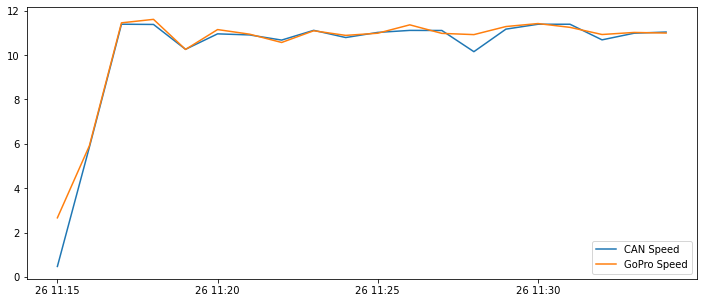

In [123]:
x = []
c_speeds = []
g_speeds = []

for st in speeds:
    if st in c_data["Tractor03"]["speed"]:
        time = unstamp(st)
        if time < datetime.datetime(2024,8,26, 11, 35):
            x.append(time)
            c_speeds.append(c_data["Tractor03"]["speed"][st][0]/2.25)
            g_speeds.append(speeds[st][0])
        else:
            break

c_speeds = np.array(c_speeds)
g_speeds = np.array(g_speeds)

plt.figure(figsize=(12,5))
plt.plot(x, c_speeds, label="CAN Speed")
plt.plot(x, g_speeds, label="GoPro Speed")
plt.legend()

ratio = c_speeds/g_speeds
print(f"{ratio.mean()=:02.5} ||| {ratio.std()=:02.5}")

In [ ]:
minutes = {
    "Telematics-Only": 0,
    "Camera-Only": 0,
    "Both": 0
}
nm = 0

for tractor in tractors:
    for st in inany(a_data[tractor]["stamps"], g_data[tractor]["stamps"]):
        if st in u_data[tractor]["stamps"]:
            if st not in c_data[tractor]["speed"]:
                minutes["Both"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Both"] += 1
            else:
                nm += 1
        elif st in a_data[tractor]["stamps"]:
            if st not in c_data[tractor]["speed"]:
                minutes["Telematics-Only"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Telematics-Only"] += 1
            else:
                nm += 1
        else:
            if st not in c_data[tractor]["speed"]:
                minutes["Camera-Only"] += 1
            elif c_data[tractor]["speed"][st][0] > MIN_SPEED:
                minutes["Camera-Only"] += 1
            else:
                nm += 1
print(f"CAN ground speed prevented counting {round(nm/60, 1)} hours of data")
minutes


CAN ground speed prevented counting 58.6 hours of data


{'Telematics-Only': 132145, 'Camera-Only': 42071, 'Both': 8644}

In [ ]:
# minutes = {'Telematics-Only': 132145, 'Camera-Only': 42071, 'Both': 8644}
hours24 = {
    "Telematics-Only": minutes["Telematics-Only"]/60,
    "Camera-Only": minutes["Camera-Only"]/60,
    "Simultaneous": minutes["Both"]/60
}

# from unify_gps.ipynb:
hours23 = {'Telematics-Only': 1425.55,
 'Camera-Only': 64.58333333333333,
 'Simultaneous': 27.833333333333332}


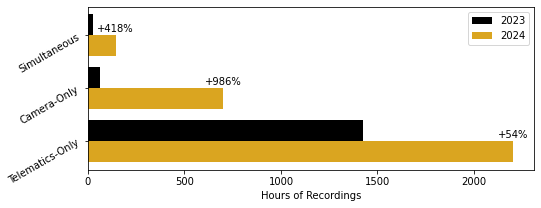

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,3))

# Plot hours of recordings for each year
bar_width = 0.4
xx = np.arange(len(hours23))
plt.barh(xx, [hours23[i] for i in hours23], bar_width, label="2023", color="black")
plt.barh(xx-bar_width, [hours24[i] for i in hours24], bar_width, label="2024", color="goldenrod")
plt.legend()
plt.xlabel("Hours of Recordings")
plt.yticks(xx-(bar_width/2), labels=list(hours23.keys()), rotation=30)

# Add percent change annotations
b0 = 0
for i in hours24:
    plt.annotate(f"+{round(100*((hours24[i]/hours23[i])-1))}%",
                   (hours24[i], xx[b0]-bar_width/3), ha="center")
    b0 += 1



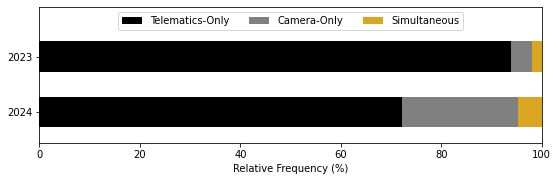

In [ ]:
total24 = sum(hours24.values())
total23 = sum(hours23.values())

plt.figure(figsize=(9,2.5))
cc = {
    'Telematics-Only': "black",
    'Camera-Only': "grey",
    'Simultaneous': "goldenrod"
}

# Prepare + plot stacked bars
co = {}
b1, b0 = 0, 0
H = 1.8*bar_width
for i in hours23:
    co[i] = plt.barh(H, 100*hours23[i]/total23, bar_width, left=b1, color=cc[i])
    plt.barh(0, 100*hours24[i]/total24, bar_width, left=b0, color=cc[i])
    b1 += 100*hours23[i]/total23
    b0 += 100*hours24[i]/total24
    
plt.legend(co.values(), co.keys(), ncols=3, loc="upper center")
plt.xlabel("Relative Frequency (%)")
plt.xlim(0,100)
plt.yticks([H,0], labels=["2023", "2024"])
plt.ylim(0-bar_width, 1.9*H)
plt.show()